In [1]:
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA

# use seaborn plotting style defaults
import seaborn as sns; sns.set()

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
train = pd.read_csv('train.csv')
X = train.iloc[:, 2:]
X.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


#Dimensionality Reduction
We already attempted to fit our full feature set with a random forest classifier and saw pretty good results. Let's see if we can improve upon things by reducing the dimensionality of our data set. Is the feature space too large/redundant?

In [50]:
#Convert X to a matrix for the dimensionality reduction
A = X.as_matrix()
A = A.T
for i in range(2, 193):
    pca = PCA(n_components = i)
    pca.fit(X)
    w = np.asarray(pca.components_)
    data_T = np.dot(w, A)
    data = data_T.T
    df = pd.DataFrame(data)
    df['species'] = train['species']
    df.to_pickle('kaggle_leaf/dim_reduced/train' + str(i) + '.pkl')

In [2]:
#Fit the data using the optimized classifier for each dimensionality reduced space
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import classifier

#Keep track of the f1 scores and optimized classifiers for the different reductions
estimators = list(np.load('forest_pca_est.npy'))
scores = list(np.load('forest_pca_scores.npy'))

#iterate through all of the files
for i in range(185,193):
    print i
    df = pd.read_pickle('kaggle_leaf/dim_reduced/train' + str(i) + '.pkl')
    X = np.asarray(df.iloc[:, :-1])
    le = preprocessing.LabelEncoder()
    le.fit(df['species'])
    y = le.transform(df['species'])
    n_examples = X.shape[0]
    n_features = X.shape[1]
    #Define the parameters to search for the forest
    rfc_params = {"n_estimators": [100],
                    "criterion": ["gini", "entropy"],
                  "max_features": np.linspace(1, int(np.sqrt(n_features) * 2), int(np.sqrt(n_features) * 2)).astype(int),
                  "max_depth": range(3, 7),
                  "min_samples_split": np.linspace(2, n_examples / 50, 10).astype(int)}
    rf = classifier.optimized_classifier(X, y, RandomForestClassifier(), rfc_params)
    estimators.append(rf[0])
    scores.append(rf[1])
    np.save('forest_pca_est.npy', estimators)
    np.save('forest_pca_scores.npy', scores)

185


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Pipeline(steps=[('robustscaler', RobustScaler(copy=True, with_centering=True, with_scaling=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features=22, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Validation Score (f1_weighted): 0.86

186
Pipeline(steps=[('robustscaler', RobustScaler(copy=True, with_centering=True, with_scaling=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features=9, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=Fa

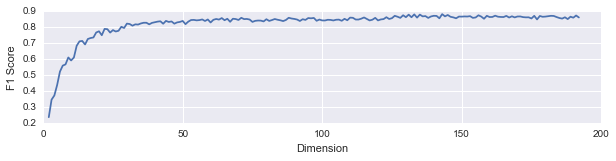

In [2]:
x = np.load('forest_pca_dim.npy')
y = np.load('forest_pca_scores2.npy')
fig, ax = plt.subplots()
ax.set_xlabel('Dimension')
ax.set_ylabel('F1 Score')
fig.set_size_inches(10, 2)
plt.plot(x,y)